# Feature extraction

### Directories

In [1]:
INPUT_DIR = "../../dataset/us-patent-phrase-to-phrase-matching/"
CPC_DIR = "../../dataset/cpc-data/"
OUTPUT_DIR = './'

## Libraries

General Libraries

In [2]:
import os
import re
import time
import math
import pickle
import random
import warnings
warnings.filterwarnings("ignore")

Scientific Libraries

In [3]:
import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
#import torch

## Data Loading

### Input Dataset

In [4]:
train = pd.read_csv(INPUT_DIR + 'train.csv')
test = pd.read_csv(INPUT_DIR + 'test.csv')
print(f"train.shape: {train.shape}")
display(train.head())

train.shape: (36473, 5)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


### CPC Data

In [5]:
# ====================================================
# CPC (Cooperative Patent Classification) Data
# ====================================================
cpc_date = '202105'
def get_cpc_texts(file_path = None, write = False):
    if file_path and write == False :
        return pd.read_csv(file_path, header = None, index_col = 0, squeeze = True).to_dict()

    else : 
        contexts = []
        pattern = '[A-Z]\d+'
        for file_name in os.listdir(f'{CPC_DIR}CPCSchemeXML{cpc_date}'):
            result = re.findall(pattern, file_name)
            if result:
                contexts.append(result)
        contexts = sorted(set(sum(contexts, [])))
        results = {}
        for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
            with open(f'{CPC_DIR}/CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
                s = f.read()
            pattern = f'{cpc}\t\t.+'
            result = re.findall(pattern, s)
            cpc_result = result[0].lstrip(pattern)
            for context in [c for c in contexts if c[0] == cpc]:
                pattern = f'{context}\t\t.+'
                result = re.findall(pattern, s)
                results[context] = cpc_result + ". " + result[0].lstrip(pattern)

        if write :
            temp = pd.DataFrame.from_dict(cpc_texts, orient='index')
            temp.to_csv(file_path, index = True, header = False)

        return results

cpc_texts = get_cpc_texts()

train['context_text'] = train['context'].map(cpc_texts).apply(lambda x: x.lower())
test['context_text'] = test['context'].map(cpc_texts).apply(lambda x: x.lower())
display(train.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,human necessities. furniture; domestic article...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,human necessities. furniture; domestic article...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,human necessities. furniture; domestic article...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,human necessities. furniture; domestic article...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,human necessities. furniture; domestic article...


# Additional Features

In [6]:
features = []

## score_map

In [7]:
train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})

## anchor_target_CPCdescription

In [8]:
features.append('anchor_target_CPCdescription')
train['anchor_target_CPCdescription'] = train['context_text'] # Anchor and Target will be added before exporting the dataset
test['anchor_target_CPCdescription'] = test['context_text'] # Anchor and Target will be added before exporting the dataset
train['anchor_target_CPCdescription'].head()[0]

'human necessities. furniture; domestic articles or appliances; coffee mills; spice mills; suction cleaners in general'

## same_anchor_similar_targets

In [9]:
features.append('same_anchor_similar_targets') # List of unique targets for same anchor
extra = train[train.score>=0.75].groupby('anchor').target.agg(list).rename('same_anchor_similar_targets') 

def add_feature(df):
    df = df.join(extra, on='anchor').fillna("")
    df['same_anchor_similar_targets'] = df.apply(lambda x:[i for i in x['same_anchor_similar_targets'] if i != x['target']], axis=1) 
    df['same_anchor_similar_targets'] = df['same_anchor_similar_targets'].apply(lambda x:', '.join(sorted(list(set(x)), key=x.index))) 
    return df

train = add_feature(train)
test = add_feature(test)

train['same_anchor_similar_targets'].head()[0]

'act of abating, abating'

In [10]:
features.append('same_anchor_targets') # List of unique targets for same anchor
extra = train.groupby('anchor').target.agg(list).rename('same_anchor_targets') 

def add_feature(df):
    df = df.join(extra, on='anchor').fillna("")
    df['same_anchor_targets'] = df.apply(lambda x:[i for i in x['same_anchor_targets'] if i != x['target']], axis=1) 
    df['same_anchor_targets'] = df['same_anchor_targets'].apply(lambda x:', '.join(sorted(list(set(x)), key=x.index))) 
    return df

train = add_feature(train)
test = add_feature(test)

train['same_anchor_targets'].head()[0]

'act of abating, active catalyst, eliminating process, forest region, greenhouse gases, increased rate, measurement level, minimising sounds, mixing core materials, multi pollution abatement device, noise reduction, pollution abatement, pollution abatement incinerator, pollution certificate, rent abatement, sorbent material, source items pollution abatement technology, stone abutments, tax abatement, water bodies, emission abatement, prevention, prophylaxis, abatement apparatus, treatment, abating, central hub, control panel, deficiency, diminished chord, diminished image, diminishing, eliminating, eliminating emissions, eliminating pollutants, increasing, increasing order, mitigation, pollution control, processing unit, removing air pollutants, subsiding, treating emissions, noise abatement'

In [11]:
features.append('pet_text')

def add_feature(df):
    df['pet_text'] = df['anchor'] + '[SEP]' + df['target'] + '[SEP]' + df['same_anchor_targets']
    return df

train = add_feature(train)
test = add_feature(test)

train['pet_text'].head()[0]

'abatement[SEP]abatement of pollution[SEP]act of abating, active catalyst, eliminating process, forest region, greenhouse gases, increased rate, measurement level, minimising sounds, mixing core materials, multi pollution abatement device, noise reduction, pollution abatement, pollution abatement incinerator, pollution certificate, rent abatement, sorbent material, source items pollution abatement technology, stone abutments, tax abatement, water bodies, emission abatement, prevention, prophylaxis, abatement apparatus, treatment, abating, central hub, control panel, deficiency, diminished chord, diminished image, diminishing, eliminating, eliminating emissions, eliminating pollutants, increasing, increasing order, mitigation, pollution control, processing unit, removing air pollutants, subsiding, treating emissions, noise abatement'

## same_anchor_context_targets

In [12]:
features.append('same_anchor_context_targets') # List of targets for the same anchor and context
extra = train.groupby(['anchor', 'context']).target.agg(list).rename('same_anchor_context_targets')

def add_feature(df):
    df = df.join(extra, on=['anchor', 'context']).fillna("")
    df['same_anchor_context_targets'] = df.apply(lambda x: ', '.join([i for i in x['same_anchor_context_targets'] if i != x['target']]), axis=1)
    return df

train = add_feature(train)
test = add_feature(test)

train['same_anchor_context_targets'].head()[0]

'act of abating, active catalyst, eliminating process, forest region, greenhouse gases, increased rate, measurement level, minimising sounds, mixing core materials, multi pollution abatement device, noise reduction, pollution abatement, pollution abatement incinerator, pollution certificate, rent abatement, sorbent material, source items pollution abatement technology, stone abutments, tax abatement, water bodies'

## same_anchor_context_similar_targets

In [13]:
features.append('same_anchor_context_similar_targets') # List of similar targets for the same anchor and context
extra = train[train.score>=0.75].groupby(['anchor', 'context']).target.agg(list).rename('same_anchor_context_similar_targets')

def add_feature(df):
    df = df.join(extra, on=['anchor', 'context']).fillna("")
    df['same_anchor_context_similar_targets'] = df.apply(lambda x: ', '.join([i for i in x['same_anchor_context_similar_targets'] if i != x['target']]), axis=1)
    return df

train = add_feature(train)
test = add_feature(test)
train['same_anchor_context_similar_targets'].head()[0]

'act of abating'

## CPCdescription_same_anchor_context_similar_targets

In [14]:
features.append('CPCdescription_same_anchor_context_similar_targets')
def add_feature(df):
    df['CPCdescription_same_anchor_context_similar_targets'] = df['anchor_target_CPCdescription'] +', '+ df['same_anchor_context_similar_targets']
    return df

train = add_feature(train)
test = add_feature(test)

train['CPCdescription_same_anchor_context_similar_targets'].head()[0]

'human necessities. furniture; domestic articles or appliances; coffee mills; spice mills; suction cleaners in general, act of abating'

## Add anchor and target to all features

In [15]:
def add_anchor_target(df):
    for f in features:
        df[f] = df['anchor'] + '[SEP]' + df['target'] + '[SEP]' + df[f]
    return df

train = add_anchor_target(train)
test = add_anchor_target(test)

## Stratification Feature: CPC-initial + Score_Map

In [16]:
train["stratification_index"] = train.context.str[:1] + train.score_map.astype(str)
train["stratification_index"].head()

0    A2
1    A3
2    A1
3    A2
4    A0
Name: stratification_index, dtype: object

In [17]:
train['score_map'].value_counts()

2    12300
1    11519
0     7471
3     4029
4     1154
Name: score_map, dtype: int64

<AxesSubplot:>

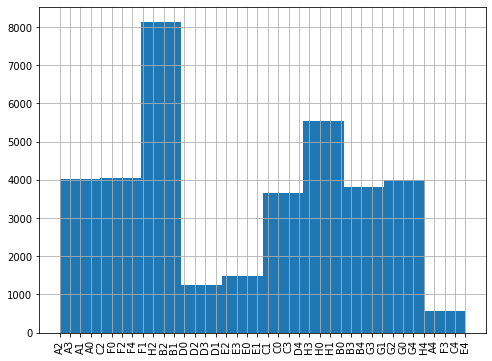

In [18]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,6))
plt.xticks(rotation=90)
train["stratification_index"].hist()

## Dataframe Export

In [19]:
train.to_csv("train_dataframe_with_features.csv", index=False)
test.to_csv("test_dataframe_with_features.csv", index=False)

# Check length of each feature

In [20]:
def concatenate_features(row):
    try:
        s = ""
        for f in row.values:
            if f not in s:
                s +=f"{f}, "
            
        return s
    except:
        pass

In [21]:
for feature in features:
    print(feature, str(train[feature].apply(lambda x: x.count(" ")).max()))

anchor_target_CPCdescription 50
same_anchor_similar_targets 94
same_anchor_targets 358
pet_text 364
same_anchor_context_targets 298
same_anchor_context_similar_targets 82
CPCdescription_same_anchor_context_similar_targets 88
